In [1]:
# Import necessary packages
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, grid)
from gerrychain.metrics import mean_median, partisan_bias, polsby_popper, efficiency_gap
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import inspect
import pickle
import geopandas as gp
from shapely.geometry import LineString, Polygon
from shapely.ops import unary_union
import itertools

In [2]:
# Import tools file
from gerrymandering_tools import *

In [97]:
# Get the graph data
utah = Graph.from_json("../../Updated_Files/Graphs/2018_full_with_clean_buffer_graph.json")
    
# Get the shapefile data
precincts = gp.read_file("../../Updated_Files/Precincts/2018_precincts_w_votes_and_pop.shp")

In [4]:
# Through observation, I have determined that the following small changes should be made

# Delete a very small polygon from the geometry of precinct 175 because it makes district 3 disconnected.
precincts.loc[175, 'geometry'] = precincts.loc[175]['geometry'][0]

# Put precinct 1887 (population zero) into district 0.
# (I believe this is an error because several online sources list that all of Summit County is in district 0.)
utah.nodes[1887]['US_Distric'] = 0
precincts.loc[1887, 'US_Distric'] = 0

The goal of this jupyter notebook is to demonstate three types of algorithmic precinct merging, which resolve the following three problems: 1) Zero-Population Precincts, 2) Discontiguities in Precinct Geometries, 3) Precincts Contained within Other Precincts. These must be done in this order. The reasoning for the ordering is as follows. Once zero-population precincts are merged with their neighbors they no longer have zero population, and no amount of merging will bring the population back down to zero. Therefore, changes will not be reverted by future merges. However, merging precincts may close off other precincts and result in more of problem 3. Therefore, this step must be performed last. 

# Section 1: Merging Zero-Population Precincts

In the precinct data there are 341 precincts that have zero population. The presence of these presence does not affect the vote shares or political data of the congressional districts, but it does affect their geometry. In particular, switching the district assignment for a zero-population precinct may change the Polsby-Popper score or the number of cut edges, while not changing the district assignment for any voters. Therefore if we allow zero-population precincts, it is possible for equivalent plans to have different cut-edge or Polsby-Popper scores. One way to resolve this issue is to merge zero-population precincts with their neighbors. This method has the additional advantage that it reduces the total number of precincts. Ceterus paribus, this means that the Markov chain generated by flipping precincts will take fewer steps to explore the sample place and to mix. 

The only question remaining is: which neighbor should a zero-population precinct node be merged with? In some sense, this does not matter, becuase the resulting merged precinct will have the same population and partisan composition in any case. Therefore, any choice would be reasonable and would not affect the accuracy of the results. The process I use below to select which neighbor should be merged is to find all adjacent precincts which are in the same county and district (under the 2010 map), and then select the one with the largest shared perimeter. Other choices are possible, but as obvserved above, they will only lead to different geometry. 

In [5]:
# Choose the graph and gdf we are working with
graph, gdf = utah, precincts

In [98]:
s = np.nonzero(precincts['POP100'].isnull().values)

In [99]:
for i in s[0]:
    precincts.loc[i, 'POP100'] = 0

In [100]:
precincts['POP100'].isnull().values.any()

False

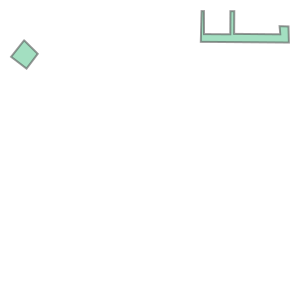

In [102]:
precincts.iloc[543]['geometry']

In [6]:
# Get all the zero-population precincts
zeros = np.array([1 if graph.nodes[n]['POP100'] == 0 else 0 for n in range(len(graph)) ])
zeros_list = [n for n in range(len(graph)) if graph.nodes[n]['POP100'] == 0 ]
print(np.count_nonzero(zeros))

0


(206340.0469999997, 696211.4729999999, 4066802.5100000007, 4681513.089999999)

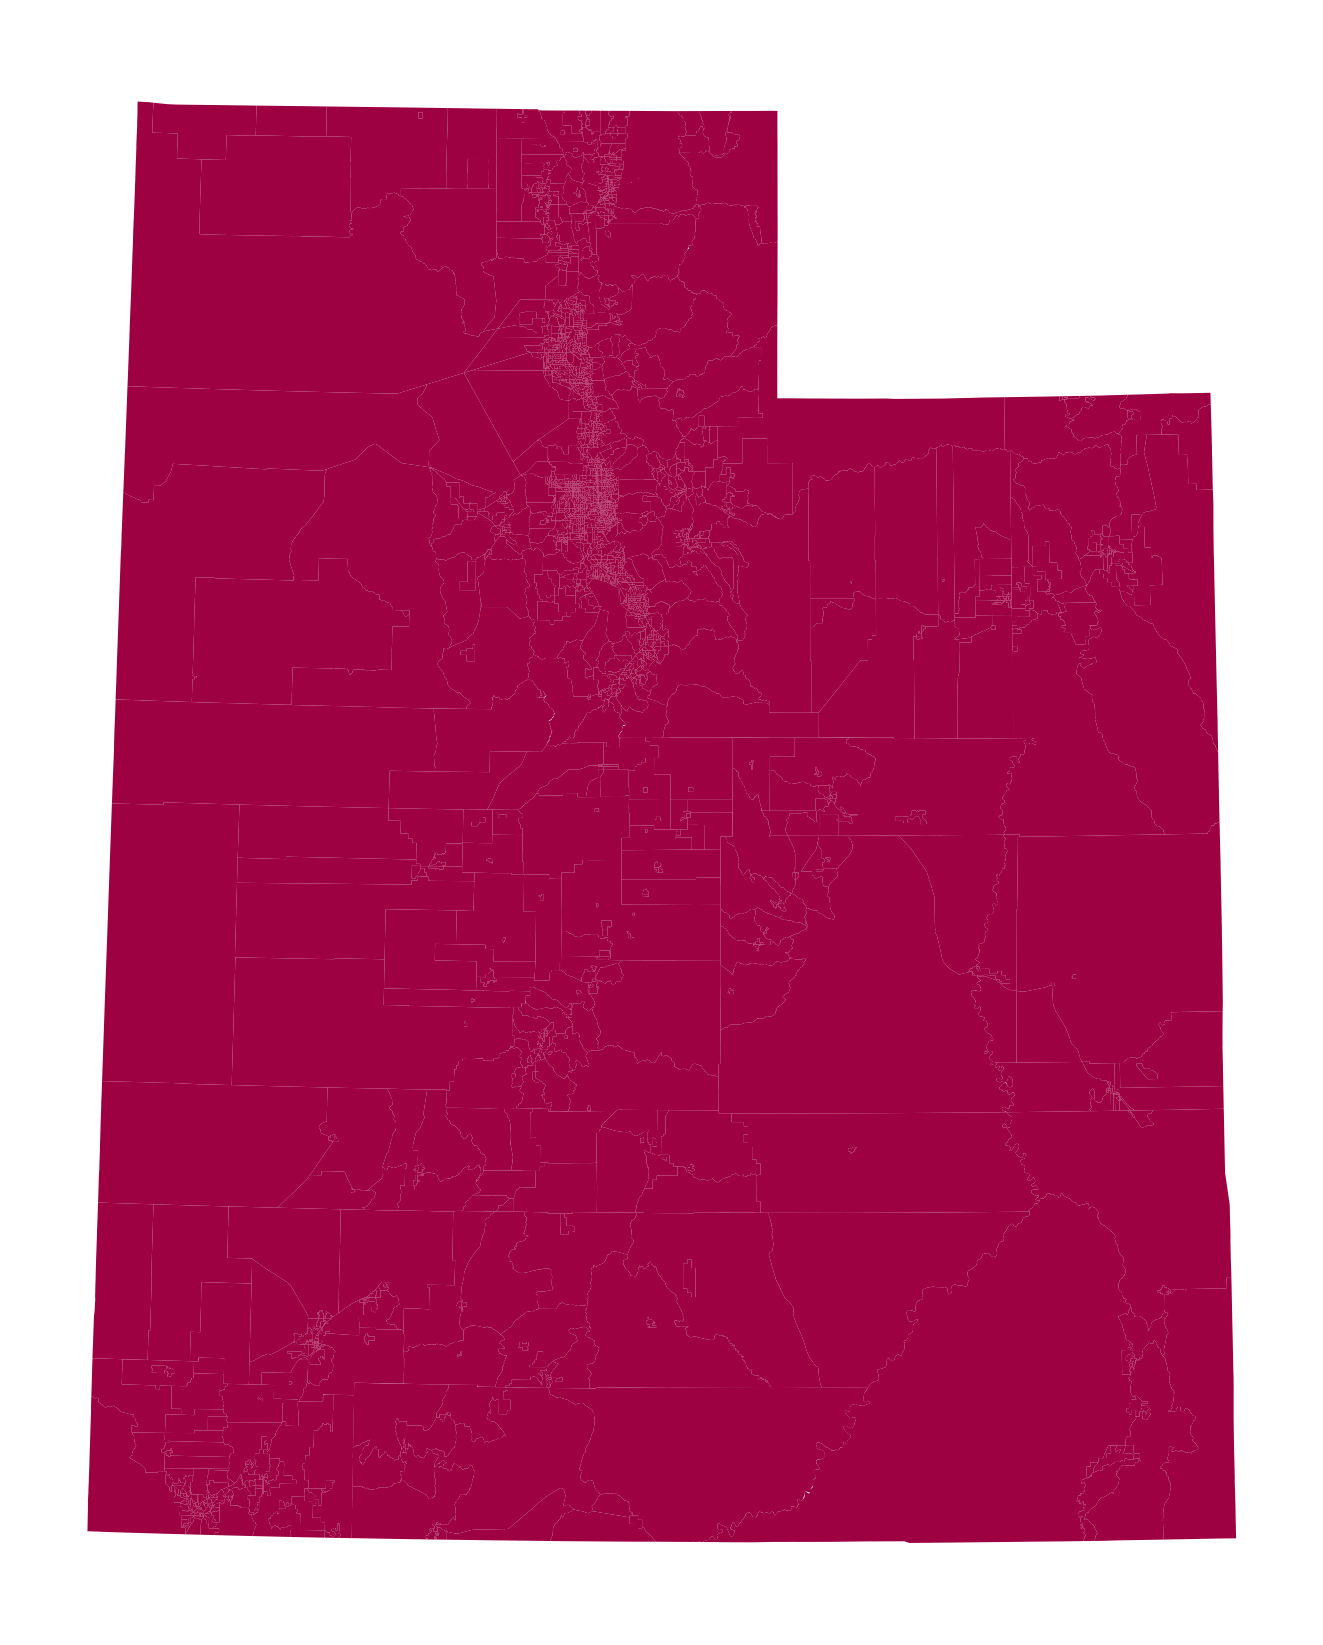

In [7]:
# Mark the zero-population nodes
f = gdf.copy()
f['zero_pop'] = zeros

# Plot the zero-population nodes
size, dpi =(14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='zero_pop', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Pop > 0, Blue: Pop = 0

In [8]:
# Get the merge
merge_zp = merge_zero_population(utah, precincts)

(206340.0469999997, 696211.4729999999, 4066802.5100000007, 4681513.089999999)

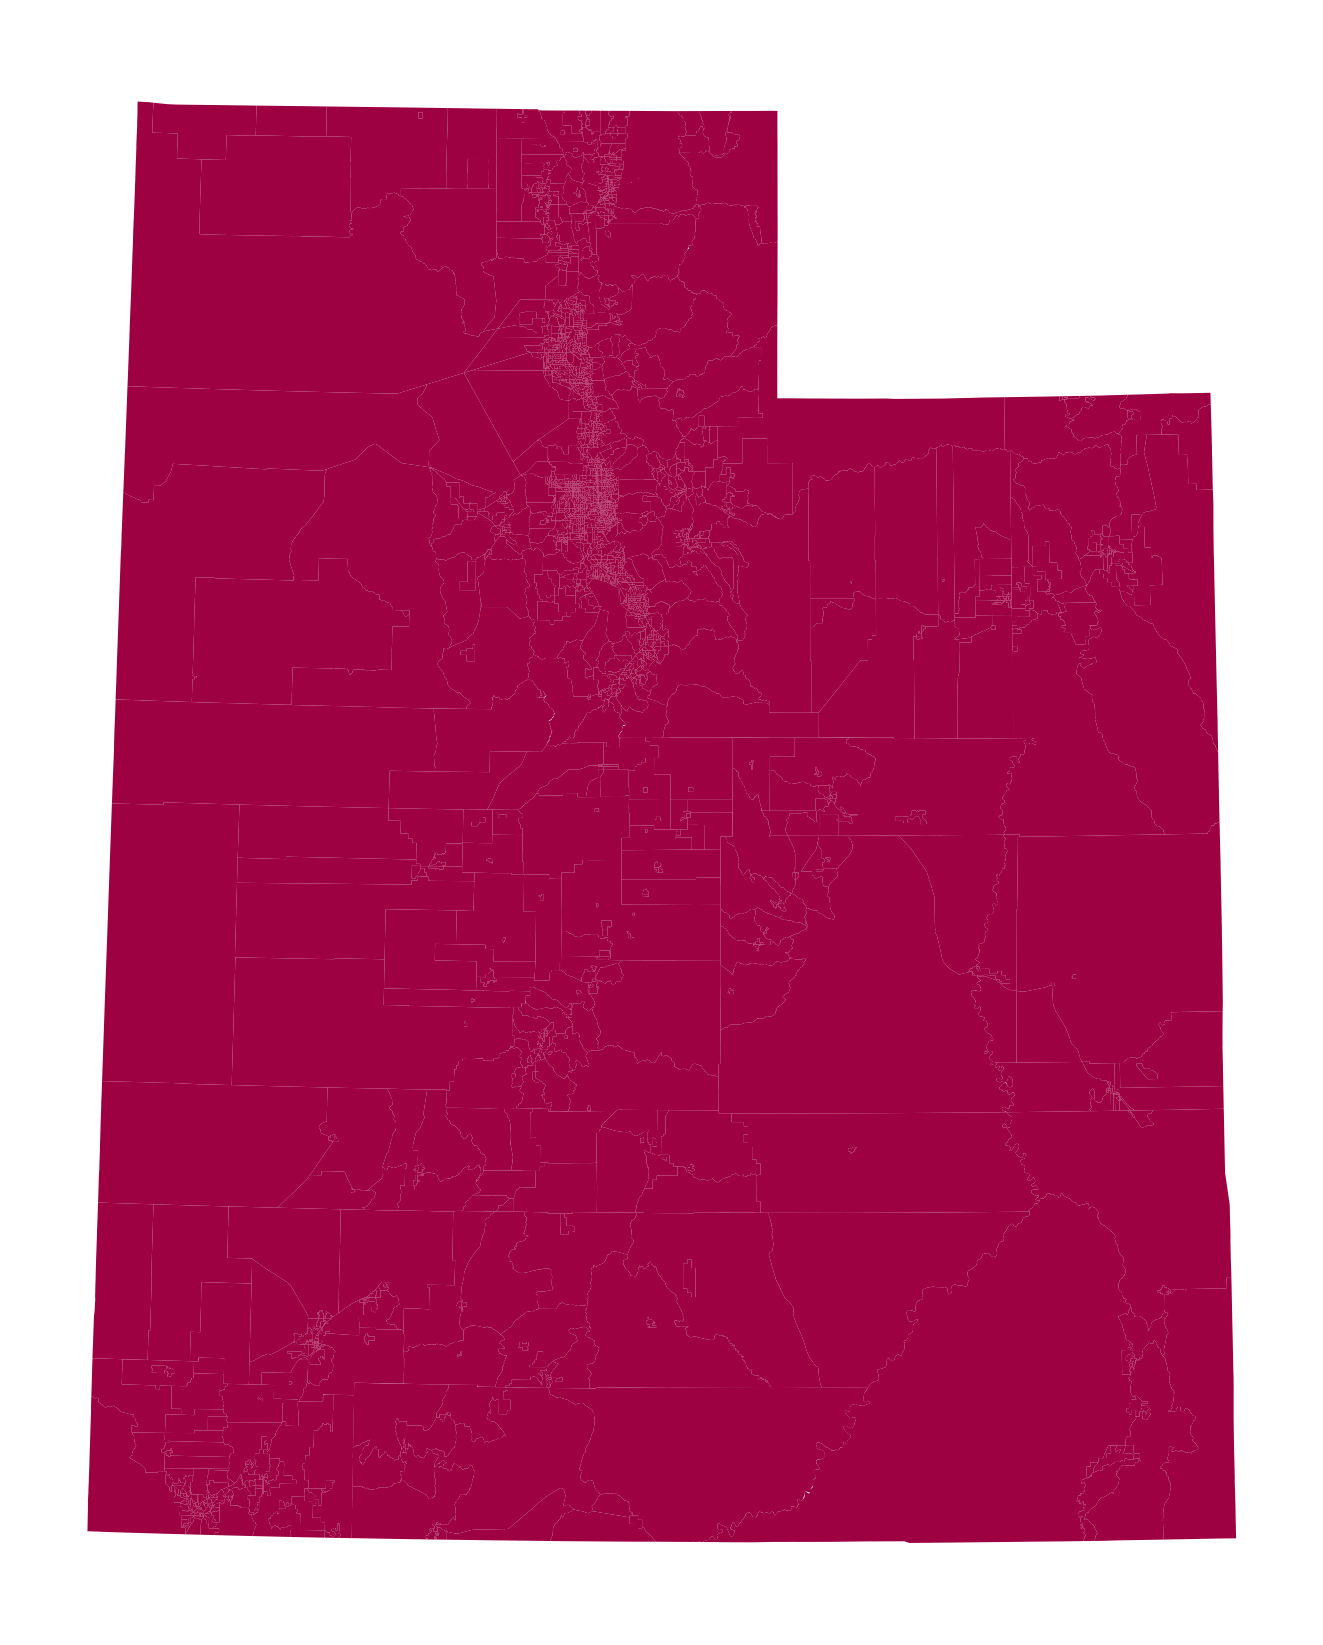

In [9]:
# Get the zero-population precincts along with the nodes they will be merged with
s = set([subpart for part in merge_zp.merges for subpart in part])
zeros_and_neighbors = np.array([1 if (n in s) else 0 for n in range(len(precincts)) ])

# Mark the zero-population nodes
f = gdf.copy()
f['zero_pop'] = 0.5*(zeros + zeros_and_neighbors)

# Plot the zero-population nodes
size, dpi = (14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='zero_pop', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Pop > 0, Blue: Pop = 0, Yellow: Neighboring precinct selected to be merged 

We have to perform the process iteratively, because some nodes may not have positive-population neighbors in the same congressional distrct and the same county. However, it turns out that we only need three iterations, and the result decreases the total number of precincts by exactly 341. 

In [10]:
# Perform the merge
graph = utah.copy()
gdf = precincts.copy()

iterations = 0
dissolves = []
merges = []
while sum( 1 for n in range(len(graph)) if graph.nodes[n]['POP100'] == 0 ) > 0:
    
    # get the merge and dissolve
    merge_zp = merge_zero_population(graph, gdf)
    dissolve_zp = merge_zp.get_dissolve()
    
    merges.append(merge_zp)
    dissolves.append(dissolve_zp)
    
    # perform the merge
    gdf = perform_dissolve_gdf(gdf, dissolve_zp)
    graph = perform_dissolve_graph(graph, dissolve_zp)
    print(gdf.columns)
    
    iterations += 1

gdf_zp = gdf
graph_zp = graph
print('Iterations: {}'.format(iterations))

Iterations: 0


The merge and dissolve objects are important because they document which precincts we merged. We can compose merges by using __mul__, and we can compose dissolves by slicing. This way we can remember which old precincts correspond to which new precincts. Technically, this information will also be recorded in the precinct metadata. The way I have written the code, the VistaID of a merged precinct is a concatenation of the VistaIDs of its constituents.

In [11]:
# Get the merge that summarizes all of the above information
merge_zp = merges[0] * merges[1] * merges[2]
dissolve_zp = merge_zp.get_dissolve(len(utah))

IndexError: list index out of range

In [12]:
# Check that the code works right
all(merge_zp.get_dissolve() == dissolves[2][dissolves[1][dissolves[0]]])

IndexError: list index out of range

In [13]:
# Check to make sure none of the new precincts have zero population

graph = graph_zp
zeros_ = np.array([1 if graph.nodes[n]['POP100'] == 0 else 0 for n in range(len(graph)) ])
print(np.count_nonzero(zeros_))

0


In [14]:
# In total, we decreased the number of precints by 341, which makes sense
len(utah) - len(graph_zp)

0

In [ ]:
# Plot the results
f = gdf_zp.copy()
f['zero_pop'] = [1 if n in dissolve_zp[zeros_list] else 0 for n in range(len(f))]

# Plot the zero-population nodes
size, dpi =(14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='zero_pop', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Pop > 0, Blue: Pop = 0

# Section 2: Merging Multipolygons

All of the precincts geometries are either a shapely Polygon or a list of shapely Polygons, called a Multipolygon. A Polygon may not be simply connected (i. e. it may have holes) but it will be connected. For Multipolygons we have no such guarantee, and in fact we have reason to suspect that they are disconnected (otherwise they could be cast into a Polygon). To make sure that our Markov chain does not generate disconnected districts, we must ensure that each of the underlying precincts are connected. We can do this by finding all of the precincts which are of type Multipolygon, and then merging them with one of their neighbors. In my code, this choice is made by determining which of the neighbors in the same county and congressional district has the largest shared perimeter with a given district, and then merging that polygon. 

In [16]:
# Choose the graph we operate on 
gdf_zp = precincts
graph_zp = utah
graph, gdf = graph_zp, gdf_zp


In [17]:
# Find the multipolygons
multipolygons = []
for i, poly in enumerate(gdf['geometry']):
    if type(poly) != Polygon:
        multipolygons.append(i)
print(multipolygons)

[17, 19, 40, 90, 101, 107, 109, 112, 118, 128, 130, 131, 137, 139, 140, 141, 142, 146, 150, 152, 156, 161, 211, 229, 235, 238, 239, 242, 248, 249, 262, 281, 315, 317, 318, 319, 321, 322, 323, 330, 331, 341, 343, 363, 395, 444, 515, 525, 532, 543, 556, 557, 569, 599, 602, 604, 607, 610, 613, 615, 624, 629, 630, 634, 636, 638, 646, 661, 670, 688, 719, 722, 749, 844, 957, 981, 1004, 1012, 1013, 1014, 1016, 1021, 1051, 1121, 1131, 1138, 1139, 1145, 1151, 1164, 1165, 1171, 1220, 1224, 1229, 1230, 1242, 1256, 1258, 1280, 1294, 1295, 1307, 1308, 1315, 1319, 1320, 1345, 1353, 1357, 1360, 1361, 1369, 1372, 1375, 1393, 1406, 1414, 1419, 1423, 1430, 1467, 1502, 1510, 1515, 1516, 1518, 1523, 1530, 1531, 1548, 1570, 1571, 1577, 1600, 1604, 1605, 1606, 1607, 1608, 1611, 1612, 1613, 1614, 1615, 1616, 1619, 1623, 1638, 1645, 1646, 1650, 1667, 1688, 1692, 1714, 1715, 1716, 1729, 1731, 1739, 1744, 1749, 1759, 1760, 1763, 1765, 1769, 1770, 1783, 1798, 1808, 1810, 1812, 1816, 1821, 1822, 1824, 1825, 1828,

In [23]:
utah[101]

AtlasView({81: {'shared_perim': 20770.48876449409, 'id': 81}, 83: {'shared_perim': 503.1028993368919, 'id': 83}, 99: {'shared_perim': 16845.731732598946, 'id': 99}, 100: {'shared_perim': 6001.593326739428, 'id': 100}, 103: {'shared_perim': 47067.27737856702, 'id': 101}, 435: {'shared_perim': 5629.341524317928, 'id': 101}, 499: {'shared_perim': 67.99532491528036, 'id': 101}, 500: {'shared_perim': 14720.663376329345, 'id': 101}, 487: {'shared_perim': 29904.135017540917, 'id': 101}, 449: {'shared_perim': 12679.540506146712, 'id': 101}})

In [27]:
utah.nodes[101]

{'boundary_node': True,
 'boundary_perim': 11543.608254409279,
 'area': 611575648.1992999,
 'index': 101.0,
 'CountyID': 8,
 'VistaID': '9:21',
 'PrecinctID': '8.09',
 'SubPrecinc': '21',
 'VersionNbr': None,
 'EffectiveD': '2012-01-01',
 'AliasName': 'Huntington 921',
 'Comments': 'jguymon',
 'RcvdDate': '2012-02-09',
 'SHAPE_Leng': 165733.478105,
 'SHAPE_Area': 611575648.199,
 'POP100': 259.0,
 'SEN_DEM': 19.779538904899134,
 'SEN_REP': 43.47766570605187,
 'G_DEM': 17.726945244956774,
 'G_REP': 51.128242074927954,
 'US_Distric': 3,
 'UT_SEN': 27,
 'UT_HOUSE': 70,
 'COUNTY': '015',
 'COUSUB': '90301',
 'PLACE': '99999',
 'PLACECC': '99',
 'TRACT': '976200',
 'BLKGRP': '4',
 'AIANHH': '9999',
 'AITS': '99999',
 'AIANHHCC': '99',
 'TTRACT': '999999',
 'TBLKGRP': '9',
 'CBSA': '99999',
 'SDUNI': '00270',
 'UrbanRural': 'Rural'}

In [52]:
s = unary_union([precincts.iloc[101]['geometry'], precincts.iloc[103]['geometry']])
print(type(s))

<class 'shapely.geometry.multipolygon.MultiPolygon'>


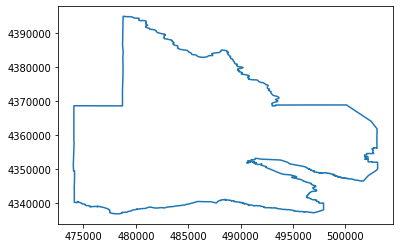

In [57]:
plt.plot(*s[0].exterior.xy)

In [51]:
precincts.iloc[101]['geometry'].area

611575648.1992999

In [19]:
type(precincts.loc[precincts["VistaID"] == '5:10']['geometry']) == Polygon

False

In [20]:
np.array([counties[graph.nodes[i]['CountyID']] for i in multipolygons])

array(['Kane', 'Tooele', 'Tooele', 'Emery', 'Emery', 'Uintah', 'Uintah',
       'Uintah', 'Uintah', 'Uintah', 'Uintah', 'Uintah', 'Uintah',
       'Uintah', 'Uintah', 'Uintah', 'Uintah', 'Uintah', 'Uintah',
       'Uintah', 'Uintah', 'Garfield', 'Piute', 'Box Elder', 'Box Elder',
       'Box Elder', 'Box Elder', 'Box Elder', 'Box Elder', 'Box Elder',
       'Box Elder', 'Iron', 'Iron', 'Iron', 'Iron', 'Iron', 'Iron',
       'Iron', 'Iron', 'Iron', 'Iron', 'Beaver', 'Beaver', 'Sevier',
       'Sevier', 'Sanpete', 'Cache', 'Cache', 'Cache', 'Cache', 'Cache',
       'Cache', 'Cache', 'Cache', 'Cache', 'Cache', 'Cache', 'Cache',
       'Cache', 'Cache', 'Cache', 'Cache', 'Cache', 'Cache', 'Cache',
       'Duchesne', 'Duchesne', 'Duchesne', 'Duchesne', 'Wasatch',
       'Wasatch', 'Wasatch', 'Washington', 'Washington', 'Davis', 'Davis',
       'Davis', 'Davis', 'Davis', 'Davis', 'Davis', 'Davis', 'Davis',
       'Davis', 'Davis', 'Davis', 'Davis', 'Davis', 'Davis', 'Davis',
       'Davis', 

In [ ]:
# Mark the multipolygons
mp = np.array([1 if i in multipolygons else 0 for i in range(len(f))])
f = gdf.copy()
f['mp'] = mp

# Plot the multipolygons
size, dpi =(14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='mp', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Polygon, Blue: Multipolygon

The first multipolygon on this list, precinct 17, is in Kane County and looks like this:

In [ ]:
# Example 1
gdf_zp.iloc[17]['geometry'] # original id: 17

It turns out that we can make this precinct into a polygon by merging it with precinct 7:

In [ ]:
# Example 2 solution
unary_union([gdf.iloc[17]['geometry'], gdf.iloc[7]['geometry']]) # original ids: 7, 17

Uintah county has a lot of these bad precincts. Here I have highlighted all of the bad ones:

In [ ]:
uintah = gdf[gdf['CountyID']==24].copy()
slice_to_set = np.zeros(len(uintah))
slice_to_set[np.array(multipolygons[1:14], dtype=np.int32)-104] = 1
uintah['MPs'] = slice_to_set

size, dpi = (3,1), 400
fig, ax = plt.subplots(figsize=size, dpi=dpi)
uintah.plot(column='MPs', ax=ax, lw=0.1)
plt.axis("off")

In [ ]:
# Example 2
gdf.iloc[107]['geometry'] # original id: 109

In [ ]:
# 118, 142 both make this a Polygon. But 145 has larger shared perimeter
s = unary_union([gdf.iloc[107]['geometry'], gdf.iloc[142]['geometry']])
s
# Original ids: 109, 120, 145

In [ ]:
# Example 3
gdf.iloc[105]['geometry'] # original id: 107

In [ ]:
# 141, 133 are possibilities (133 wins)
s = unary_union([gdf.iloc[105]['geometry'], gdf.iloc[133]['geometry']])
s
# Original ids: 107, 136, 144

In [ ]:
# Example 4: what a weird precinct
gdf.iloc[526]['geometry'] # original precinct id: 543

In [ ]:
# Here we need to use two neighbors to make this a polygon: This one needs 570 and 568 to make it a polygon
s = unary_union([gdf.iloc[526]['geometry'], gdf.iloc[570]['geometry'], gdf.iloc[568]['geometry']])
s
# Original ids: 543, 590, 592

In [ ]:
# Example 5: Wow
gdf.iloc[1582]['geometry'] # Original precinct id: 1729

In [ ]:
# 1632 and 1668 are needed
s = unary_union([gdf.iloc[1582]['geometry'], gdf.iloc[1455]['geometry'], gdf.iloc[1490]['geometry']])
s

As we can see above, in many cases, we simply have to search for one adjacent precinct to merge to make a precinct into a polygon. However, in some cases, we need multiple adjacent polygons to do the job. This is further complicated by the fact that some multipolygons are adjacent to other multipolygons, which might resolve some islands when merged but leave others beyond the adjacency reach of the first multipolygon. This is all dealt with in my code merge_multipolygons.

In [ ]:
multipolygons = []
for i, poly in enumerate(gdf['geometry']):
        if type(poly) != Polygon:
            multipolygons.append(i)
print(multipolygons)

In [ ]:
# time to run: approx 1 min
merge_mp = merge_multipolygons(graph, gdf)
dissolve_mp = merge_mp.get_dissolve()

In [ ]:
# Get the multipolygons along with the nodes they will be merged with
f = gdf.copy()
s = set([subpart for part in merge_mp.merges for subpart in part])
mps_and_neighbors = np.array([1 if (n in s) else 0 for n in range(len(f)) ])

f['mp'] = 0.5*(mp + mps_and_neighbors)

# Plot the zero-population nodes
size, dpi = (14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='mp', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Polygon, Blue: Multipolygon, Yellow: Neighboring precinct selected to be merged 

In [ ]:
merge_zp_mp = merge_zp * merge_mp
dissolve_zp_mp = merge_zp_mp.get_dissolve()

In [ ]:
# Perform the merge
gdf_zp_mp = perform_dissolve_gdf(gdf_zp, dissolve_mp)
graph_zp_mp = perform_dissolve_graph(graph_zp, dissolve_mp)

In [ ]:
# We decreased by
len(graph_zp) - len(graph_zp_mp)

In [ ]:
# Plot the results

f = gdf_zp_mp.copy()
f['mp'] = np.array([1 if i in dissolve_mp[multipolygons] else 0 for i in range(len(f))])

# Plot the multipolygons
size, dpi =(14,7), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='mp', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Polygon, Blue: Merged Multipolygon

# Section 3: One Neighbor Precincts and Separating Precincts

One essential motivation for merging precincts is to streamline the process of using Monte Carlo Markov Chain models via the flip proposal. The flip proposal is the transition between states in our Markov chain. It selects a precinct on one of the cut edges of the graph, and then changes its district assignment to the adjacent district. This transition forms a reversible Markov Chain. By simulating thousands of these flips, we hope to explore the sample space of possible districting plans. However, the flip proposal has some limitations. In particular, if precint A is contained inside precinct B (and thus has no other neighboring precincts) and precinct B is selected to be flipped, when the new districting assignment is generated, B's old district will be left discontiguous and thus invalid, because A will be a disconnected precinct in the old district. The algorithm will reject the new proposed plan due to its invalidity. Therefore, the precinct B (and precinct A) can never be flipped into a different district, and the Markov chain will not explore the whole sample space, and may be confined to a particular region of the sample space. Of course, the solution is that A and B can be flipped if they are flipped together. The simplest way to proceed is to use the normal flipping algorithm, but after having merged precincts A and B.

In [ ]:
# Choose the graph we operate on 
graph, gdf = graph_zp_mp, gdf_zp_mp

In [ ]:
# Find all the one-neighbor precincts
lengths, ids, neighbor_ids, containers, merge1 = get_one_neighbor(graph)

In [ ]:
# Some examples: original ids 35 / 52, 36 / 74
gdf.iloc[35]['geometry'] # original id 36

In [ ]:
gdf.iloc[72]['geometry'] # original id 74

In [ ]:
plt.bar(np.arange(35), lengths)
plt.title("Number of Neighbors by Precinct")
plt.xlabel("Number of Neighbors")
plt.ylabel("Number of Precincts")
plt.show()

In [ ]:
# Mark the one-neighbor nodes
f = gdf.copy()
f["one neighbor"] = np.array([1 if i in ids + neighbor_ids else 0 for i in range(len(f))])

# Plot the one neighbor precincts with their one neighbor
size, dpi =(3,2), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='one neighbor', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Normal Precinct, Blue: Precint with only one neighbor, or containing such a precinct

But there are some precincts that contain more than one adjacent precinct. How do we find these?

In [ ]:
dissolve_zp_mp[450]

In [ ]:
# For example, this precinct, which contains 5 other precincts, 
# two of which are adjacent, so they are not "one neighbor precincts"
gdf.iloc[404]['geometry'] # original id: 450

These could be termed "separating precincts" because if we remove them from the adjacency graph, the resulting graph is disconnected. This is the foundation for the get_separators algorithm which finds all of these precincts

In [ ]:
# Find all the separating precincts, approx 5 min
ids2, neighbor_ids2, separators, merge_sp = get_separators(graph)

In [ ]:
# Make sure it is performing correctly

# This should print nothing
for node in neighbor_ids:
    if node not in neighbor_ids2:
        print(node)
        
print('')

# This could print some precincts (the additional ones, like 404)
for node in neighbor_ids2:
    if node not in neighbor_ids:
        print(node)

In [ ]:
merge1 in merge_sp

In [ ]:
# Mark the one-neighbor nodes
f = gdf.copy()
f["one neighbor"] = np.array([1 if (i in ids2 or i in neighbor_ids2) else 0 for i in range(len(f))])

# Plot the one neighbor precincts with their one neighbor
size, dpi =(3,2), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='one neighbor', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Normal Precinct, Blue: Separating precinct, or precinct contained in it

# plt.savefig("isolated_precincts2.png", dpi=dpi, bbox_inches="tight")

# Look at Sanpete County!

In [ ]:
dissolve_sp = merge_sp.get_dissolve()

# Merge so that the new merged precincts are flippable
gdf_zp_mp_sp = perform_dissolve_gdf(gdf_zp_mp, dissolve_sp)
graph_zp_mp_sp = perform_dissolve_graph(graph_zp_mp, dissolve_sp)

In [ ]:
merge_zp_mp_sp = merge_zp_mp * merge_sp
dissolve_zp_mp_sp = merge_zp_mp_sp.get_dissolve()

In [ ]:
# Mark the merged precincts
f = gdf_zp_mp_sp.copy()
f["one neighbor"] = np.array([1 if (n in dissolve_sp[ids2] or n in dissolve_sp[neighbor_ids2]) else 0 for n in range(len(f))])

# Plot the one neighbor precincts with their one neighbor
size, dpi =(3,2), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
f.plot(column='one neighbor', ax=ax, cmap='Spectral')
plt.axis("off")

# Legend: Red: Normal Precinct, Blue: Separating precinct, or precinct contained in it (Merged)
# plt.savefig("isolated_precincts_merged1.png", dpi=dpi, bbox_inches="tight")

In [ ]:
# We decreased by
len(graph_zp_mp) - len(graph_zp_mp_sp)

In [ ]:
# Take a look at this precinct, the same one I showed before. All of its holes are patched up
gdf_zp_mp_sp.iloc[345]['geometry'] # original id: 450

Now we can check to see that these new geometries and adjacencies do, in fact, satisfy all the properties we claim:

In [ ]:
# No zero population nodes
all(graph_zp_mp_sp.nodes[n]['POP100'] > 0 for n in graph_zp_mp_sp.nodes)

In [ ]:
# No multipolygons
all(type(poly) == Polygon for poly in gdf_zp_mp_sp['geometry'])

In [ ]:
# No separating precincts (approx 5 min to run)
separate = []
for node in graph_zp_mp_sp:
    copy = graph_zp_mp_sp.copy()
    copy.remove_node(node)
    separate.append(nx.is_connected(copy))
all(separate)

In [ ]:
# Check that the total population stayed the same
sum(graph_zp_mp_sp.nodes[n]['POP100'] for n in graph_zp_mp_sp.nodes) == sum(utah.nodes[n]['POP100'] for n in utah.nodes)

In [ ]:
len(graph_zp_mp_sp)

Now we can package these files up:

In [ ]:
# gdf_zp_mp_sp.to_file("gdf_zp_mp_sp.shp")

In [ ]:
# pickle.dump(graph_zp_mp_sp, open("graph_zp_mp_sp.pkl", 'wb'))

# Section 4: Check to see which cut edges are "unflippable"

In [ ]:
my_updaters = {"population": updaters.Tally("POP100", alias="population"),
               "d": updaters.Tally("DEM", alias="d"),
               "r": updaters.Tally("REP", alias="r"),
               "polsby_popper": polsby_popper,
               "split_counties": SplitCounties()
              }

elections = [ Election("SEN10", {"Dem": "DEM", "Rep": "REP"})]

election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

initial_partition = GeographicPartition(graph_zp_mp_sp, "US_Distric", my_updaters)
problematic_edges = []
for edge in initial_partition['cut_edges']:
    a, b = edge[0], edge[1]
    f1 = constraints.single_flip_contiguous(initial_partition.flip({a: initial_partition.assignment[b]}))
    f2 = constraints.single_flip_contiguous(initial_partition.flip({b: initial_partition.assignment[a]}))
    
    if not (f1 and f2):
        problematic_edges.append(edge)

In [ ]:
problematic_edges

# Look at the results:

In [ ]:
# Plot with isolated precincts removed
plot_graph(gdf_zp_mp_sp, graph_zp_mp_sp, dpi=400, size=7, save=False, savetitle='graph_after_merging1.png')